In [79]:
import re
import random
import pandas as pd
import hashlib

In [80]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [81]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Email Auth and Security,564.278639,70.534830,123.204231,8
Azure Functions + Visual Studio,880.465550,110.058194,174.356686,8
Debugging in VS Code,1092.052694,99.277518,194.928947,11
Logging in Python,1300.609400,92.900671,240.416033,14
Azure AD Authentication,1368.304316,105.254178,267.018293,13
Azure Private DNS,1402.806769,73.831935,155.844460,19
VMWare,1548.048262,36.001122,66.714960,43
C# Basics,1600.429305,51.626752,96.258898,31
RAG Project,1637.112983,102.319561,223.663830,16
Azure DevOps Pipelines,2058.740425,79.182324,242.148585,26


# Histogram

sum of ages: ~57583.07


<Axes: >

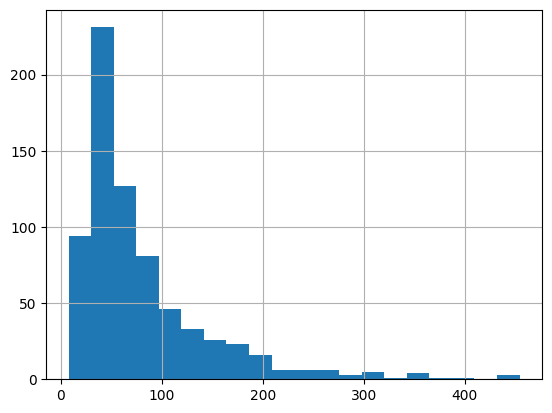

In [82]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [83]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [84]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [85]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [86]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [87]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [88]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [89]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [90]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [91]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 713
Total card age: 57583.07


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
80,JavaScript Concepts,GraphQL: A query language for APIs that allows...,7e7b34d3208558b7ef2938d10bb39b64,-348.142687,-110.298341,348.142687,5073.723703,0.155848,0,0
81,JavaScript Concepts,Lazy Loading: Deferring the loading of non-cri...,b2d7160e58720a8441c71f99cb8fcec5,-279.612491,-110.298341,348.142687,5073.723703,0.155848,3,0
82,JavaScript Concepts,While Loop\nwhile (condition) {\n // Code t...,d2df8fce97a9927ff5941c1db9405753,-206.733854,-110.298341,348.142687,5073.723703,0.155848,6,0
83,JavaScript Concepts,Angular: A comprehensive framework by Google f...,98c8161dd75d5af5639bb6107dc07cc9,-161.123445,-110.298341,348.142687,5073.723703,0.155848,9,0
84,JavaScript Concepts,React Hooks: Functions like useState and useEf...,6567c10a38c31c55b459fac590318cce,-136.949303,-110.298341,348.142687,5073.723703,0.155848,12,0
85,JavaScript Concepts,Destructuring: Syntax for unpacking values fro...,cf45c67e3fe6d2cc720996005c958996,-117.143148,-110.298341,348.142687,5073.723703,0.155848,15,0
86,JavaScript Concepts,Promises: Objects representing the eventual co...,5f4d3efe8780f646899e998663742dbc,-94.145529,-110.298341,348.142687,5073.723703,0.155848,18,0
87,JavaScript Concepts,Template Literals: Use template literals for s...,58f571472c67253fdcba8bd496d963db,-82.812530,-110.298341,348.142687,5073.723703,0.155848,21,0
88,JavaScript Concepts,Middleware: Functions in frameworks like Expre...,4a4154d0bb96cb5e884e43746f817099,-71.130738,-110.298341,348.142687,5073.723703,0.155848,24,0
89,JavaScript Concepts,"Yarn: An alternative package manager to npm, o...",70273b4e931be2d99e6061559bdf2f39,-59.493891,-110.298341,348.142687,5073.723703,0.155848,27,0


## Age Max

In [92]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [93]:
# n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [94]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [95]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
156,Azure Functions + PP365,HTTP Triggers\nA type of function trigger that...,b9e42ab2e8e591023bd1aa43b8509bfc,-454.471559,-102.959249,454.471559,2162.144238,0.540373,0,0
245,Azure Developer Associate,What are the two primary data types collected ...,f0995a4e3eae52ece78cb2f025efcf7f,-449.205528,-80.798733,449.205528,6302.301158,0.071520,0,0
482,Azure Developer Associate,Which Azure storage service supports a user de...,fd19a76de5cbe2ba07dc309378571330,-443.862139,-80.798733,449.205528,6302.301158,0.071520,1,1
60,PnP PowerShell,Secure Password Handling\nPractices for managi...,274158ed857c87a86d296e65705f10da,-402.270762,-96.219355,402.270762,5773.161277,0.488894,0,0
399,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f4ebac7aac964a3452e1734f5f37fcea,-376.156947,-102.959249,454.471559,2162.144238,0.540373,1,1
125,Python,Q:\nWhat are the two essential methods that an...,558bcbe4e40c504fe6e977eb903fb48d,-355.958621,-101.795465,355.958621,3257.454879,0.421220,0,0
307,PnP PowerShell,System.IO.Stream (System.IO)\nRepresents a seq...,3f146f4a53f3f36ced6256f3cfc16375,-352.733775,-96.219355,402.270762,5773.161277,0.488894,1,1
80,JavaScript Concepts,GraphQL: A query language for APIs that allows...,7e7b34d3208558b7ef2938d10bb39b64,-348.142687,-110.298341,348.142687,5073.723703,0.155848,0,0
246,Azure Developer Associate,Which role grants least privilege to allow a u...,72ce544617e81069d717793d0c83d443,-347.352026,-80.798733,449.205528,6302.301158,0.071520,2,2
483,Azure Developer Associate,What is a namespace in Azure Container Registr...,1b0ac1c1e13236781412e83d16112ac2,-327.137826,-80.798733,449.205528,6302.301158,0.071520,3,0


In [96]:
existing_cards.head(10).sum()

head                   JavaScript ConceptsJavaScript ConceptsJavaScri...
body                   GraphQL: A query language for APIs that allows...
hash                   7e7b34d3208558b7ef2938d10bb39b64b2d7160e58720a...
age                                                         -1557.287615
subject_mean_age                                            -1102.983414
subject_highest_age                                          3481.426873
subject_age_sum                                             50737.237031
head_random_roll                                                1.558477
count                                                                135
n_fold                                                                 0
dtype: object

In [97]:
existing_cards['age'].mean()

-80.76167543278423